In [0]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Mnistの例

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.MNIST(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)

Processing...
Done!


In [0]:
#ネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

num_epochs = 10
optimizer = None
scheduler = None

In [0]:
#最適化関数とスケジューラを可変で渡せる関数
def main(net, optimizer, scheduler):
    criterion = nn.CrossEntropyLoss()
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        #train
        net.train()
        for i, (images, labels) in enumerate(train_loader):
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          train_acc += (outputs.max(1)[1] == labels).sum().item()
          loss.backward()
          #パラメータ更新
          optimizer.step()
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)

        #val
        net.eval()
        with torch.no_grad():
          for images, labels in test_loader:        
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)

        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}' 
                       .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        if scheduler != None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:            
                scheduler.step()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

# SGD


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0123, val_loss: 0.0021, val_acc: 0.9600, lr：0.01
Epoch [2/10], Loss: 0.0049, val_loss: 0.0014, val_acc: 0.9718, lr：0.01
Epoch [3/10], Loss: 0.0038, val_loss: 0.0010, val_acc: 0.9787, lr：0.01
Epoch [4/10], Loss: 0.0033, val_loss: 0.0009, val_acc: 0.9827, lr：0.01
Epoch [5/10], Loss: 0.0029, val_loss: 0.0008, val_acc: 0.9827, lr：0.01
Epoch [6/10], Loss: 0.0027, val_loss: 0.0007, val_acc: 0.9855, lr：0.01
Epoch [7/10], Loss: 0.0025, val_loss: 0.0007, val_acc: 0.9866, lr：0.01
Epoch [8/10], Loss: 0.0024, val_loss: 0.0007, val_acc: 0.9849, lr：0.01
Epoch [9/10], Loss: 0.0022, val_loss: 0.0006, val_acc: 0.9882, lr：0.01
Epoch [10/10], Loss: 0.0022, val_loss: 0.0006, val_acc: 0.9876, lr：0.01


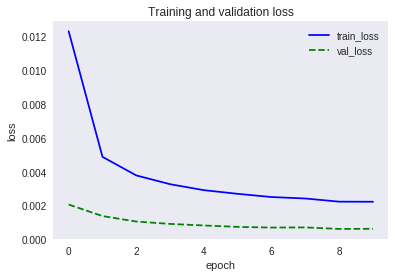

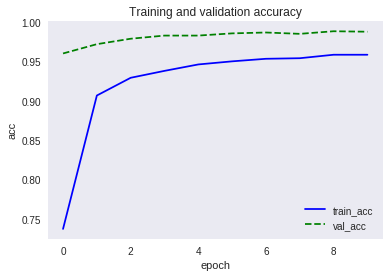

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## Adadelta


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.Adadelta(net.parameters(), rho=0.9)
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0074, val_loss: 0.0015, val_acc: 0.9702, lr：1.0
Epoch [2/10], Loss: 0.0038, val_loss: 0.0012, val_acc: 0.9767, lr：1.0
Epoch [3/10], Loss: 0.0032, val_loss: 0.0010, val_acc: 0.9816, lr：1.0
Epoch [4/10], Loss: 0.0029, val_loss: 0.0008, val_acc: 0.9833, lr：1.0
Epoch [5/10], Loss: 0.0026, val_loss: 0.0007, val_acc: 0.9852, lr：1.0
Epoch [6/10], Loss: 0.0025, val_loss: 0.0008, val_acc: 0.9846, lr：1.0
Epoch [7/10], Loss: 0.0024, val_loss: 0.0008, val_acc: 0.9849, lr：1.0
Epoch [8/10], Loss: 0.0024, val_loss: 0.0008, val_acc: 0.9849, lr：1.0
Epoch [9/10], Loss: 0.0023, val_loss: 0.0007, val_acc: 0.9874, lr：1.0
Epoch [10/10], Loss: 0.0023, val_loss: 0.0008, val_acc: 0.9853, lr：1.0


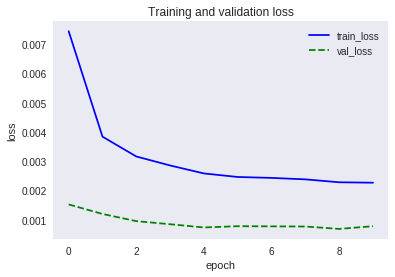

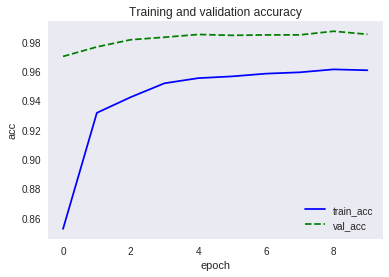

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## Adagrad


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.Adagrad(net.parameters())
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0086, val_loss: 0.0024, val_acc: 0.9523, lr：0.01
Epoch [2/10], Loss: 0.0055, val_loss: 0.0019, val_acc: 0.9599, lr：0.01
Epoch [3/10], Loss: 0.0048, val_loss: 0.0017, val_acc: 0.9650, lr：0.01
Epoch [4/10], Loss: 0.0043, val_loss: 0.0016, val_acc: 0.9687, lr：0.01
Epoch [5/10], Loss: 0.0041, val_loss: 0.0015, val_acc: 0.9705, lr：0.01
Epoch [6/10], Loss: 0.0040, val_loss: 0.0014, val_acc: 0.9726, lr：0.01
Epoch [7/10], Loss: 0.0038, val_loss: 0.0014, val_acc: 0.9735, lr：0.01
Epoch [8/10], Loss: 0.0036, val_loss: 0.0013, val_acc: 0.9740, lr：0.01
Epoch [9/10], Loss: 0.0036, val_loss: 0.0012, val_acc: 0.9748, lr：0.01
Epoch [10/10], Loss: 0.0034, val_loss: 0.0012, val_acc: 0.9752, lr：0.01


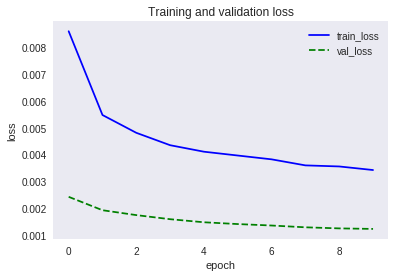

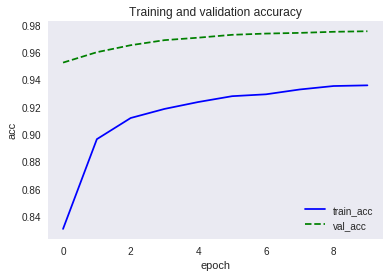

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## Adam


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.Adam(net.parameters())
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0093, val_loss: 0.0019, val_acc: 0.9608, lr：0.001
Epoch [2/10], Loss: 0.0044, val_loss: 0.0012, val_acc: 0.9748, lr：0.001
Epoch [3/10], Loss: 0.0035, val_loss: 0.0010, val_acc: 0.9790, lr：0.001
Epoch [4/10], Loss: 0.0031, val_loss: 0.0009, val_acc: 0.9800, lr：0.001
Epoch [5/10], Loss: 0.0028, val_loss: 0.0008, val_acc: 0.9835, lr：0.001
Epoch [6/10], Loss: 0.0026, val_loss: 0.0007, val_acc: 0.9849, lr：0.001
Epoch [7/10], Loss: 0.0025, val_loss: 0.0007, val_acc: 0.9861, lr：0.001
Epoch [8/10], Loss: 0.0023, val_loss: 0.0007, val_acc: 0.9868, lr：0.001
Epoch [9/10], Loss: 0.0022, val_loss: 0.0006, val_acc: 0.9882, lr：0.001
Epoch [10/10], Loss: 0.0022, val_loss: 0.0006, val_acc: 0.9869, lr：0.001


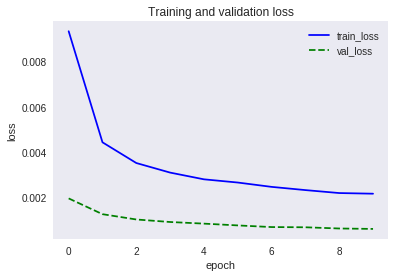

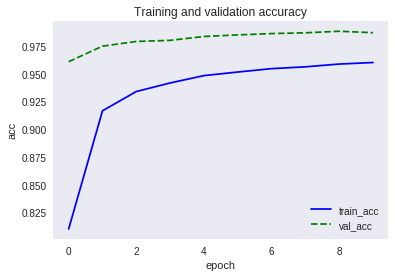

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## RMSprop


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.RMSprop(net.parameters())
scheduler = None
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0109, val_loss: 0.0022, val_acc: 0.9570, lr：0.01
Epoch [2/10], Loss: 0.0060, val_loss: 0.0019, val_acc: 0.9629, lr：0.01
Epoch [3/10], Loss: 0.0053, val_loss: 0.0018, val_acc: 0.9643, lr：0.01
Epoch [4/10], Loss: 0.0051, val_loss: 0.0015, val_acc: 0.9712, lr：0.01
Epoch [5/10], Loss: 0.0049, val_loss: 0.0015, val_acc: 0.9726, lr：0.01
Epoch [6/10], Loss: 0.0050, val_loss: 0.0013, val_acc: 0.9740, lr：0.01
Epoch [7/10], Loss: 0.0048, val_loss: 0.0017, val_acc: 0.9699, lr：0.01
Epoch [8/10], Loss: 0.0048, val_loss: 0.0014, val_acc: 0.9729, lr：0.01
Epoch [9/10], Loss: 0.0048, val_loss: 0.0023, val_acc: 0.9534, lr：0.01
Epoch [10/10], Loss: 0.0047, val_loss: 0.0016, val_acc: 0.9711, lr：0.01


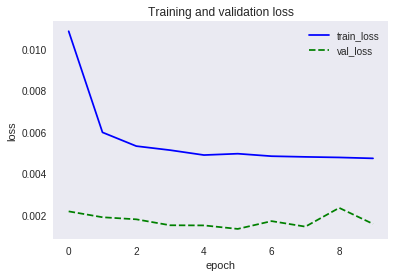

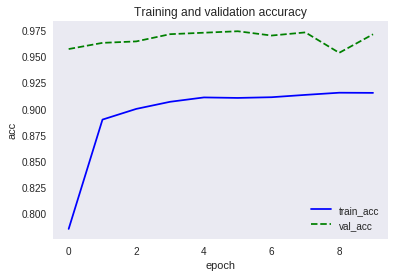

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

# 学習率を調整する




In [0]:
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

## LambdaLR


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
lambda1 = lambda epoch: 1.0 / num_epochs
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0359, val_loss: 0.0358, val_acc: 0.2003, lr：0.001
Epoch [2/10], Loss: 0.0353, val_loss: 0.0345, val_acc: 0.4339, lr：0.001
Epoch [3/10], Loss: 0.0324, val_loss: 0.0260, val_acc: 0.6398, lr：0.001
Epoch [4/10], Loss: 0.0231, val_loss: 0.0134, val_acc: 0.7967, lr：0.001
Epoch [5/10], Loss: 0.0167, val_loss: 0.0093, val_acc: 0.8442, lr：0.001
Epoch [6/10], Loss: 0.0139, val_loss: 0.0077, val_acc: 0.8679, lr：0.001
Epoch [7/10], Loss: 0.0123, val_loss: 0.0067, val_acc: 0.8846, lr：0.001
Epoch [8/10], Loss: 0.0112, val_loss: 0.0060, val_acc: 0.8950, lr：0.001
Epoch [9/10], Loss: 0.0104, val_loss: 0.0054, val_acc: 0.9062, lr：0.001
Epoch [10/10], Loss: 0.0098, val_loss: 0.0051, val_acc: 0.9125, lr：0.001


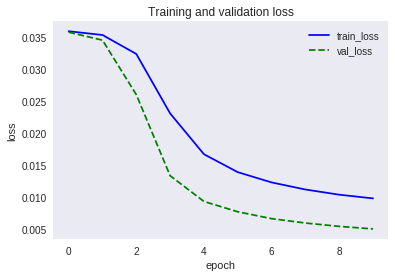

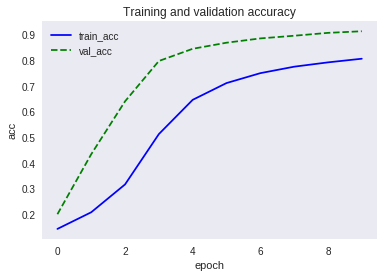

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## StepLR


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
#2エポックごとに0.1を掛ける。
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0206, val_loss: 0.0054, val_acc: 0.9013, lr：0.01
Epoch [2/10], Loss: 0.0085, val_loss: 0.0034, val_acc: 0.9343, lr：0.01
Epoch [3/10], Loss: 0.0065, val_loss: 0.0026, val_acc: 0.9491, lr：0.01
Epoch [4/10], Loss: 0.0056, val_loss: 0.0023, val_acc: 0.9528, lr：0.001
Epoch [5/10], Loss: 0.0054, val_loss: 0.0023, val_acc: 0.9548, lr：0.001
Epoch [6/10], Loss: 0.0053, val_loss: 0.0023, val_acc: 0.9552, lr：0.00010000000000000002
Epoch [7/10], Loss: 0.0053, val_loss: 0.0022, val_acc: 0.9556, lr：0.00010000000000000002
Epoch [8/10], Loss: 0.0053, val_loss: 0.0022, val_acc: 0.9556, lr：1.0000000000000003e-05
Epoch [9/10], Loss: 0.0052, val_loss: 0.0022, val_acc: 0.9556, lr：1.0000000000000003e-05
Epoch [10/10], Loss: 0.0053, val_loss: 0.0022, val_acc: 0.9556, lr：1.0000000000000002e-06


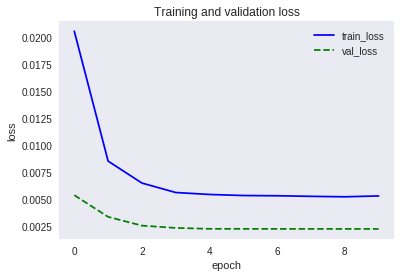

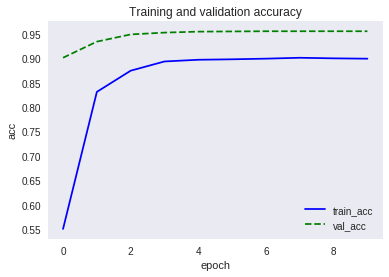

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## MultiStepLR



In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
#5エポックとに10エポックでガンマを掛ける。
scheduler = MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0186, val_loss: 0.0048, val_acc: 0.9150, lr：0.01
Epoch [2/10], Loss: 0.0078, val_loss: 0.0029, val_acc: 0.9419, lr：0.01
Epoch [3/10], Loss: 0.0061, val_loss: 0.0022, val_acc: 0.9554, lr：0.01
Epoch [4/10], Loss: 0.0054, val_loss: 0.0019, val_acc: 0.9618, lr：0.01
Epoch [5/10], Loss: 0.0048, val_loss: 0.0018, val_acc: 0.9644, lr：0.01
Epoch [6/10], Loss: 0.0045, val_loss: 0.0016, val_acc: 0.9684, lr：0.01
Epoch [7/10], Loss: 0.0041, val_loss: 0.0015, val_acc: 0.9711, lr：0.001
Epoch [8/10], Loss: 0.0041, val_loss: 0.0015, val_acc: 0.9703, lr：0.001
Epoch [9/10], Loss: 0.0039, val_loss: 0.0015, val_acc: 0.9708, lr：0.001
Epoch [10/10], Loss: 0.0040, val_loss: 0.0014, val_acc: 0.9727, lr：0.001


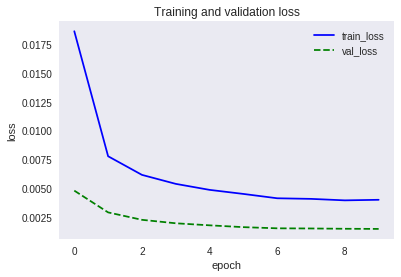

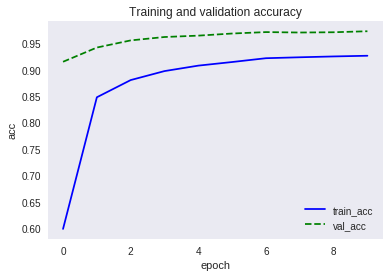

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## ExponentialLR


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = ExponentialLR(optimizer, gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/10], Loss: 0.0230, val_loss: 0.0059, val_acc: 0.8967, lr：0.01
Epoch [2/10], Loss: 0.0088, val_loss: 0.0035, val_acc: 0.9323, lr：0.01
Epoch [3/10], Loss: 0.0071, val_loss: 0.0031, val_acc: 0.9420, lr：0.001
Epoch [4/10], Loss: 0.0070, val_loss: 0.0031, val_acc: 0.9424, lr：0.00010000000000000002
Epoch [5/10], Loss: 0.0069, val_loss: 0.0031, val_acc: 0.9427, lr：1.0000000000000003e-05
Epoch [6/10], Loss: 0.0068, val_loss: 0.0031, val_acc: 0.9427, lr：1.0000000000000002e-06
Epoch [7/10], Loss: 0.0068, val_loss: 0.0031, val_acc: 0.9427, lr：1.0000000000000002e-07
Epoch [8/10], Loss: 0.0069, val_loss: 0.0031, val_acc: 0.9427, lr：1.0000000000000004e-08
Epoch [9/10], Loss: 0.0069, val_loss: 0.0031, val_acc: 0.9427, lr：1.0000000000000005e-09
Epoch [10/10], Loss: 0.0068, val_loss: 0.0031, val_acc: 0.9427, lr：1.0000000000000006e-10


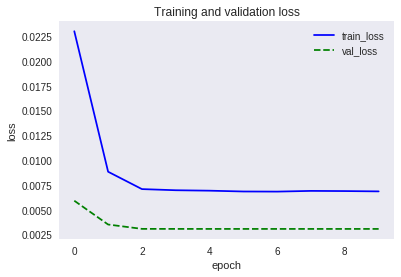

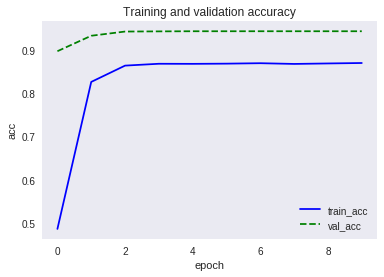

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## ReduceLROnPlateau


In [35]:
num_epochs = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)
train_loss_list, train_acc_list, val_loss_list, val_acc_list = main(net, optimizer, scheduler)

Epoch [1/12], Loss: 0.0203, val_loss: 0.0055, val_acc: 0.8953, lr：0.01
Epoch [2/12], Loss: 0.0083, val_loss: 0.0034, val_acc: 0.9341, lr：0.01
Epoch [3/12], Loss: 0.0065, val_loss: 0.0024, val_acc: 0.9519, lr：0.01
Epoch [4/12], Loss: 0.0055, val_loss: 0.0021, val_acc: 0.9590, lr：0.01
Epoch [5/12], Loss: 0.0049, val_loss: 0.0019, val_acc: 0.9623, lr：0.001
Epoch [6/12], Loss: 0.0048, val_loss: 0.0019, val_acc: 0.9632, lr：0.001
Epoch [7/12], Loss: 0.0047, val_loss: 0.0018, val_acc: 0.9639, lr：0.001
Epoch [8/12], Loss: 0.0047, val_loss: 0.0018, val_acc: 0.9641, lr：0.0001
Epoch [9/12], Loss: 0.0047, val_loss: 0.0018, val_acc: 0.9642, lr：0.0001
Epoch [10/12], Loss: 0.0046, val_loss: 0.0018, val_acc: 0.9645, lr：0.0001
Epoch [11/12], Loss: 0.0046, val_loss: 0.0018, val_acc: 0.9644, lr：1e-05
Epoch [12/12], Loss: 0.0046, val_loss: 0.0018, val_acc: 0.9644, lr：1e-05


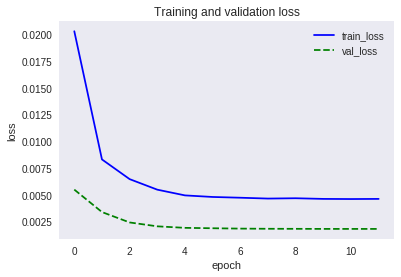

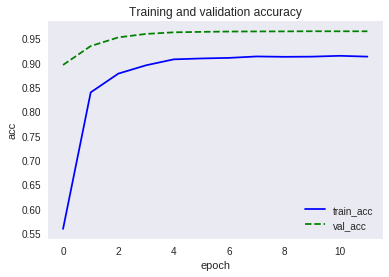

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()